<a href="https://colab.research.google.com/github/yukyeongmin/model/blob/main/lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LeNet5의 구조는 다음과 같다.
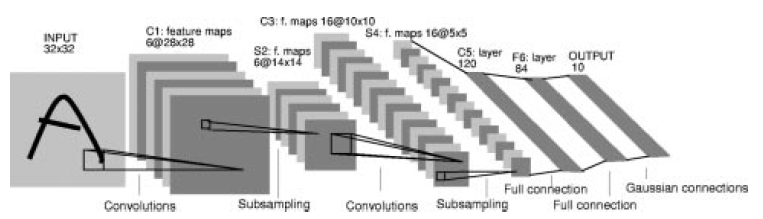

## LeNet 5의 구조

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, ZeroPadding2D

In [ ]:
# 주의 - 다음의 코드는 논문에 나와있는 것과는 다릅니다.
#        keras를 이용하여 간단하게 구현한 버전이라고 생각하시면 됩니다.

LeNet5 = Sequential()
LeNet5.add(ZeroPadding2D(padding=2))
LeNet5.add(Conv2D(filters=6, kernel_size=5, padding="valid", strides=1, activation="tanh"))
LeNet5.add(AveragePooling2D(pool_size=2, strides=2))
LeNet5.add(Conv2D(filters=16, kernel_size=5, padding="valid", strides=1, activation="tanh"))
LeNet5.add(AveragePooling2D(pool_size=2, strides=2))
LeNet5.add(Flatten())
LeNet5.add(Dense(units=120, activation="tanh"))
LeNet5.add(Dense(units=84, activation="tanh"))
LeNet5.add(Dense(units=10, activation="softmax"))

LeNet5.build(input_shape=(None,28,28,1))
LeNet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 32, 32, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                        

## LeNet5 학습

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

LeNet5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
LeNet5.fit(x_train, y_train, epochs=20)


In [ ]:
test_loss, test_acc = LeNet5.evaluate(x_test, y_test)
print(test_acc)

313/313 [==============================] - 4s 11ms/step - loss: 0.0523 - accuracy: 0.9860
0.9860000014305115


## 훈련시킨 모델을 저장하자

모델을 훈련시키는데 시간이 소요되는데 나중에는 다시 훈련시키지 않고 모델을 불러와서 바로 사용할수 있도록 모델을 저장하고 불러오는 코드를 작성해 봅시다.
하지만 colab의 content폴더에 저장하게 되면 나중에 다시 켰을때 남아있지 않기 때문에 google drive와 연동해서 저장해보겠습니다.

In [ ]:
import os
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
filename = "trained_model"
path = "/content/gdrive/MyDrive/Colab Notebooks/coffee_LeNet/"

LeNet5.save(os.path.join(path, filename))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/coffee_LeNet/trained_model/assets


## 저장한 모델을 불러오자

In [ ]:
pretrained = tf.keras.models.load_model(os.path.join(path,filename))

In [ ]:
pretrained.evaluate(x_test,y_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.0523 - accuracy: 0.9860


[0.05226082727313042, 0.9860000014305115]

저장하기전 evaluate했을때와 같은 결과가 나옴을 확일할수 있습니다.

## 각 layer의 출력을 살펴보자

우리는 우리가 학습시킨 모델이 어떤 생각을 가지고 그렇게 예측하는 건지 알수가 없습니다. 모델의 각 층의 매개변수를 확인해 볼수야 있겠지만 그 의미를 인간인 우리가 할수는 없겠죠. 
간접적으로나마 model의 생각을 확인할 방법이 있는데, 
학습된 모델에서 각 layer통과할 때마다 input이 어떻게 바뀌어 가는지를 확인하는 것입니다.

https://androidkt.com/get-output-of-intermediate-layers-keras/ 를 참고하여 작성했습니다.

그림판에서 28x28pixel에 맞게 숫자를 적어 왔습니다.

In [ ]:
# 그림판에서 직접 만들어온 32x32크기의 이미지를 먼저 불러 오겠습니다.
# 이미지를 불러오는 방법은 여러가지 겠지만 저는 이미지를 numpy형태로 불러 오기 위해 다음의 방법을 사용했습니다.

from PIL import Image
import numpy as np

image = Image.open(os.path.join(path,"handwritten_number_1.png"))
image = np.array(image)

(28, 28, 3)


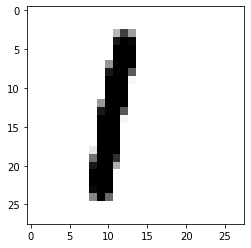

In [ ]:
# 잘 불러왔는지 확인해봅시다
plt.imshow(image)
print(image.shape)

In [ ]:
def visualize_conv_layer(model, layer_name, test_image):
  
  layer_output=model.get_layer(layer_name).output

  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)

  intermediate_prediction=intermediate_model.predict(test_image.reshape(1,28,28,1))

  print(np.shape(intermediate_prediction))
  
  fig,ax=plt.subplots(1,intermediate_prediction.shape[3],figsize=(32,10))

  for i in range(intermediate_prediction.shape[3]):
      ax[i].imshow(intermediate_prediction[0, :, :, i], cmap='gray')

In [ ]:
def visualize_dense_layer(model, layer_name, test_image):
  
  layer_output=model.get_layer(layer_name).output

  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)

  intermediate_prediction=intermediate_model.predict(test_image.reshape(1,28,28,1))

  print(np.shape(intermediate_prediction))
  
  fig,ax=plt.subplots(figsize=(50,10))

  ax.imshow(intermediate_prediction, cmap='gray')

(1, 28, 28, 6)


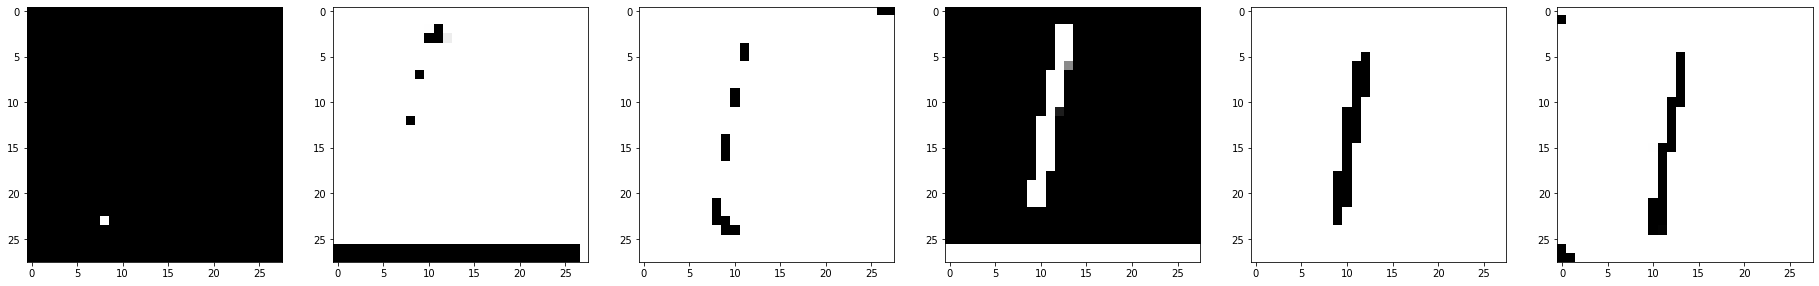

In [ ]:
visualize_conv_layer(pretrained, "conv2d", image[:,:,0])

(1, 14, 14, 6)


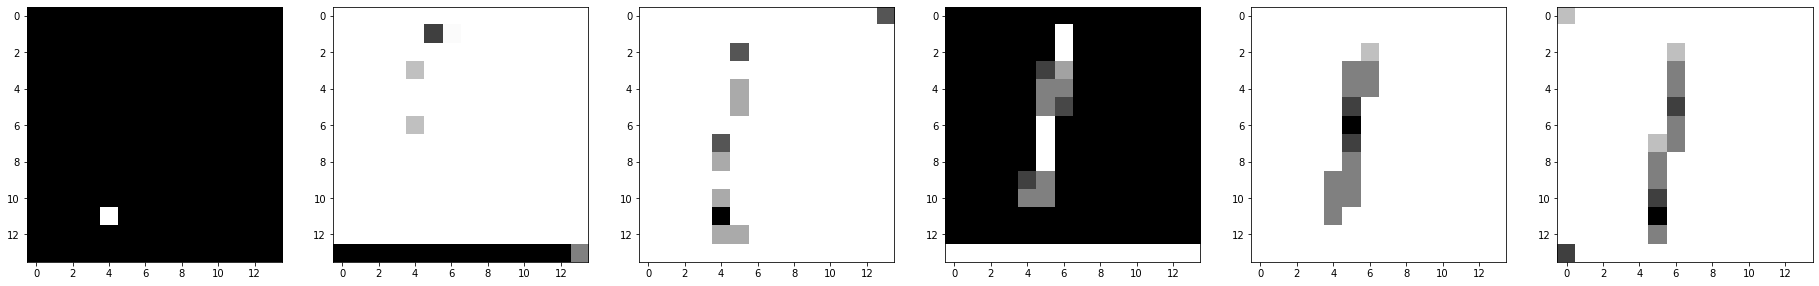

In [ ]:
visualize_conv_layer(pretrained, "average_pooling2d", image[:,:,0])

(1, 10, 10, 16)


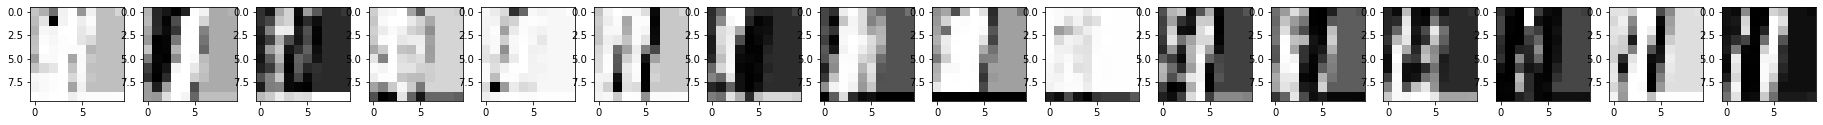

In [ ]:
visualize_conv_layer(pretrained, "conv2d_1", image[:,:,0])

(1, 5, 5, 16)


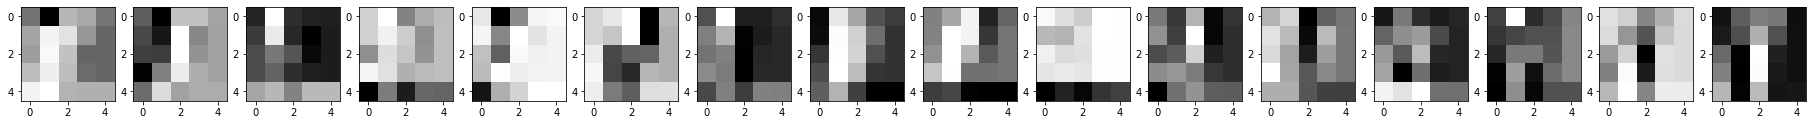

In [ ]:
visualize_conv_layer(pretrained, "average_pooling2d_1", image[:,:,0])

(1, 400)


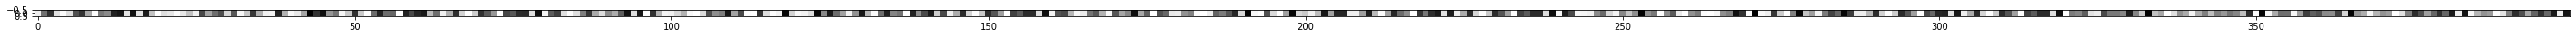

In [ ]:
visualize_dense_layer(pretrained, "flatten", image[:,:,0])

(1, 120)


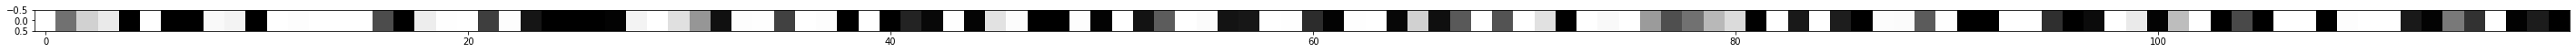

In [ ]:
visualize_dense_layer(pretrained, "dense", image[:,:,0])

(1, 84)


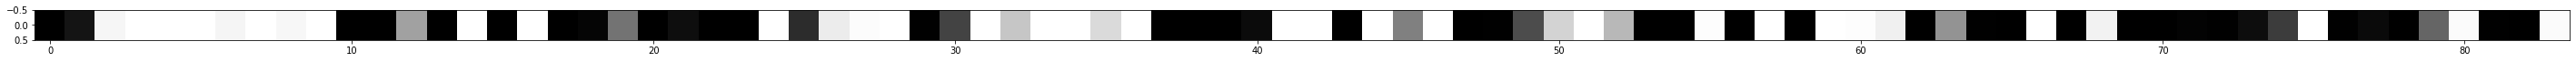

In [ ]:
visualize_dense_layer(pretrained, "dense_1", image[:,:,0])

(1, 10)


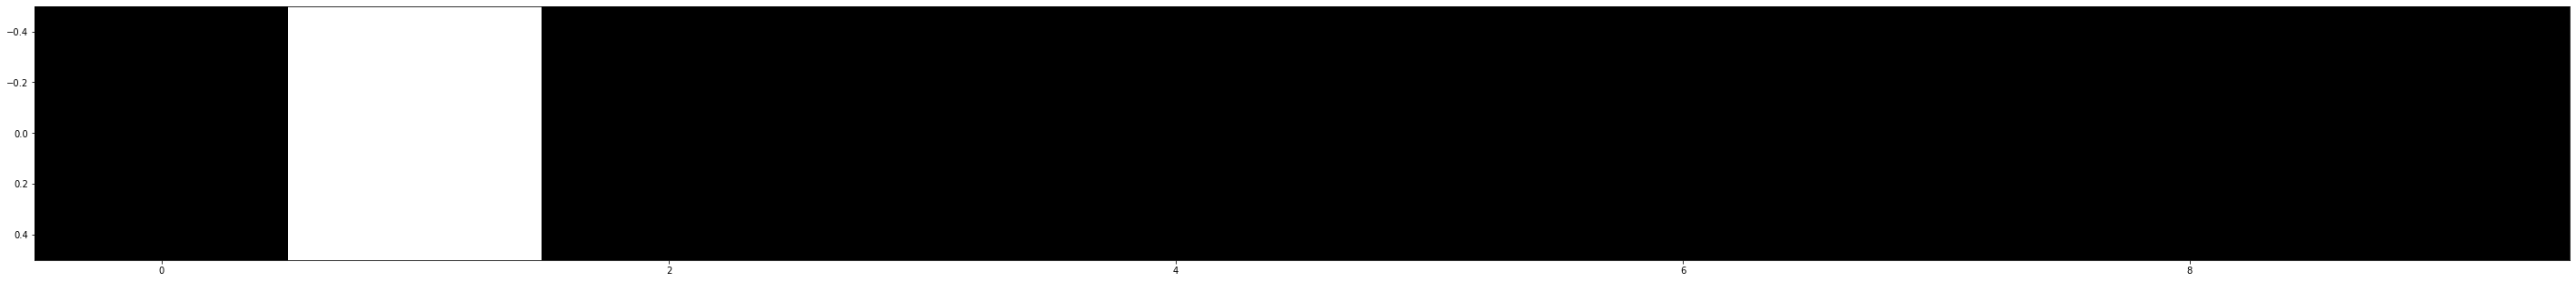

In [ ]:
visualize_dense_layer(pretrained, "dense_2", image[:,:,0])

In [ ]:
pretrained.predict(image[:,:,0].reshape(1,28,28,1))

array([[1.2255096e-07, 9.9996054e-01, 2.3900650e-09, 4.9897011e-09,
        5.1500433e-06, 3.3924849e-10, 3.2902033e-05, 1.0397526e-06,
        2.3083862e-07, 3.9372658e-10]], dtype=float32)

## 각 layer의 parameter를 출력해보자!

layer의 output을 확인해보는것으로도 만족스럽지 않다면??
굳이 각 layer의 kernel을 확인해보고 싶다면?!!

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/ 링크를 참고하여 만들었습니다.

In [ ]:
def visualize_kernel(model,i): # it_layer
  filters, biases = model.layers[i].get_weights()
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min) 

  print(filters.shape)
  plt.figure(figsize=(20,5))
  for j in range(filters.shape[3]):
    ax = plt.subplot(1, filters.shape[3],j+1)
    # get the filter
    f = filters[:, :, :, j]
    plt.imshow(f[:,:,0], cmap='gray')

  # show the figure
  plt.show()


(5, 5, 1, 6)


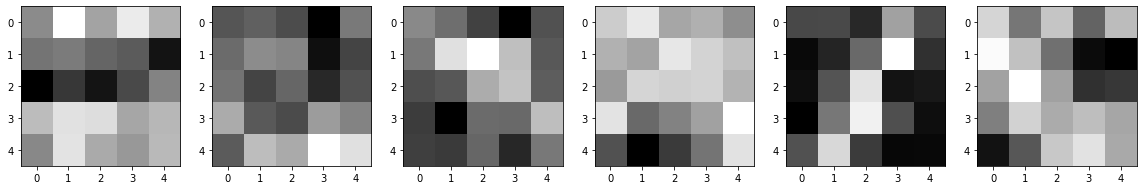

In [ ]:
visualize_kernel(pretrained, 1)

(5, 5, 6, 16)


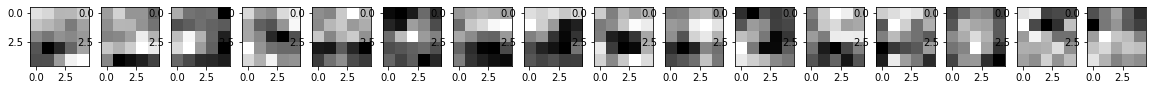

In [ ]:
visualize_kernel(pretrained, 3)